# Metrics and Plots for the trained models

This notebook aims to viz results from metrics that were already saved in `results/scores_tables`

> [!NOTE]  
> normalization only applied to create protein embeddings

This notebook shows only protein embeddings performance along with gene expreession, as they are super competitive

## Viz

In [20]:
version='v2.11'
norm='minmax'

In [21]:
import pandas as pd
import sys,os
sys.path.append(os.path.abspath('../../../src/ml'))


from evaluator import Evaluator
from collector import ResultsCollector
from visualizer import DashboardVisualizer



In [22]:
avg_df=pd.read_csv('../../../results/score_tables/scores_avg_seeds.csv')
all_df=pd.read_csv('../../../results/score_tables/scores_all_seeds.csv')

In [23]:
input_data=[
 'gene_expression',

 'Complex_protein_embeddings',
 'RGCN_protein_embeddings',
 'weighted_RGCN_protein_embeddings',
 'GraphSAGE_protein_embeddings',
 'GAT_protein_embeddings',
#  'concatenated_protein_embeddings',

#  'Complex_sample_embeddings',
#  'RGCN_sample_embeddings',
#  'weighted_RGCN_sample_embeddings',
#  'GraphSAGE_sample_embeddings',
#  'GAT_sample_embeddings'
#  'concatenated_sample_embeddings'
]

In [24]:
df=avg_df
filtered_results=df[
        (df['input']=='gene_expression') 
        | ((df['version']==version) & (df['normalization']==norm))
        | (
            (norm != 'none')
            & df['input'].isin([
                'RGCN_sample_embeddings',
                'Complex_sample_embeddings',
                'concatenated_sample_embeddings'
            ])
            & (df['version']==version)
        )
]


For better foucsed results, consider only non pytorch mlp models and CompEx and RGCN only (the others gnns are not done yet)

So run this if metrics files contatin them

In [25]:
filtered_results=filtered_results[filtered_results['model']!='pytorch_mlp']
# -- only input in input_data
filtered_results=filtered_results[filtered_results['input'].isin(input_data)]

In [26]:


SECONDARY_COLORS = {
    1: "#C60B46",  # pms-1945
    2: "#ED145B",  # pms-206
    3: "#EE3524",  # pms-1795
    4: "#F37320",  # pms-1665
    5: "#7C2A90",  # pms-2602
    6: "#7D6AAF",  # pms-2725
    7: "#C6671D", # pms-153
    8: "#FEBC18", # pms-123
    9: "#004E7D",  # pms-295
    10: "#0E87C9", # pms-2935
    11: "#0094B5", # pms-314
    12: "#46C3D2", # pms-3115
    13: "#00807A",  # pms-3292
    14: "#40B769", # pms-355
    15: "#8CC63E", # pms-376
    16: "#D5DF3D" # pms-381
}
vibrant_colors = [
    SECONDARY_COLORS[2],
    SECONDARY_COLORS[4],
    SECONDARY_COLORS[6],
    SECONDARY_COLORS[8],
    SECONDARY_COLORS[11],
    SECONDARY_COLORS[14]
]
dataset_colors={
    'gene_expression': SECONDARY_COLORS[2],# -- redish
    'Complex_protein_embeddings': SECONDARY_COLORS[11],
    'GAT_protein_embeddings': SECONDARY_COLORS[4],
    'GraphSAGE_protein_embeddings': SECONDARY_COLORS[14],
    'RGCN_protein_embeddings': SECONDARY_COLORS[6],
    'weighted_RGCN_protein_embeddings': SECONDARY_COLORS[8],
}

### 3. radar plot

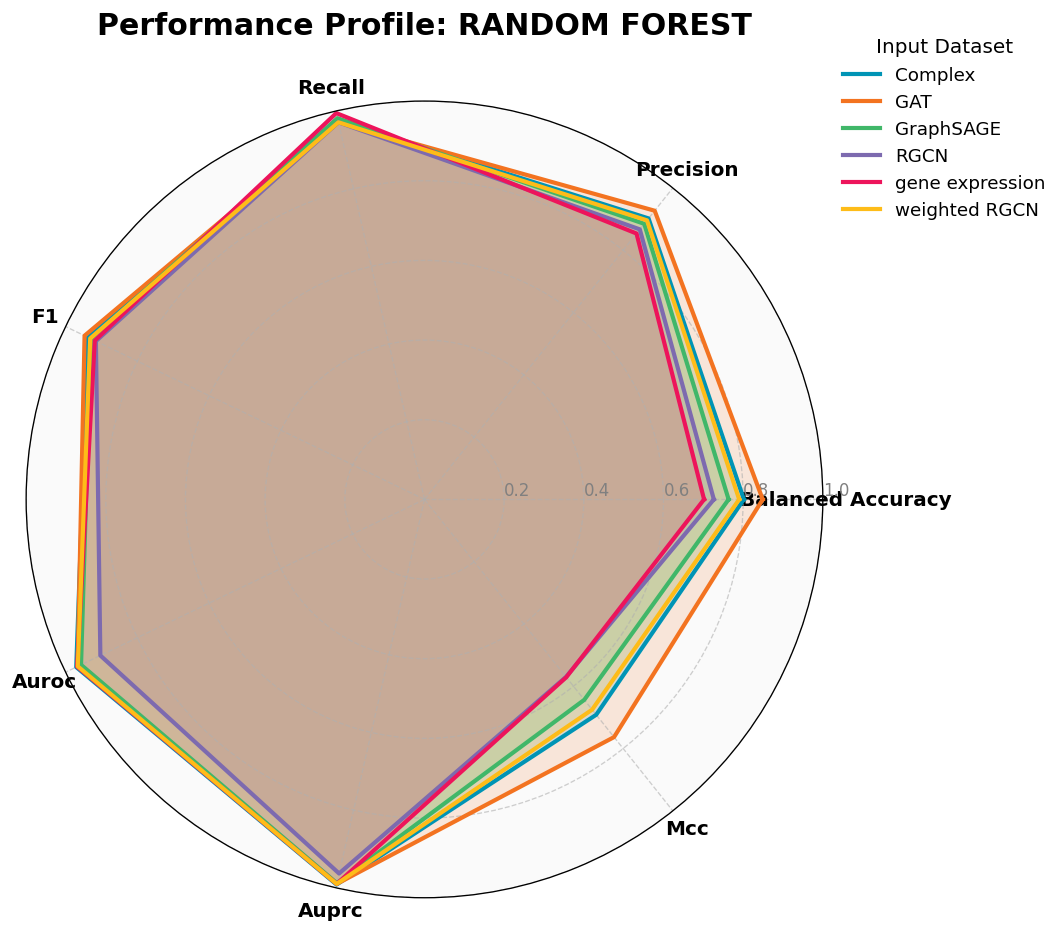

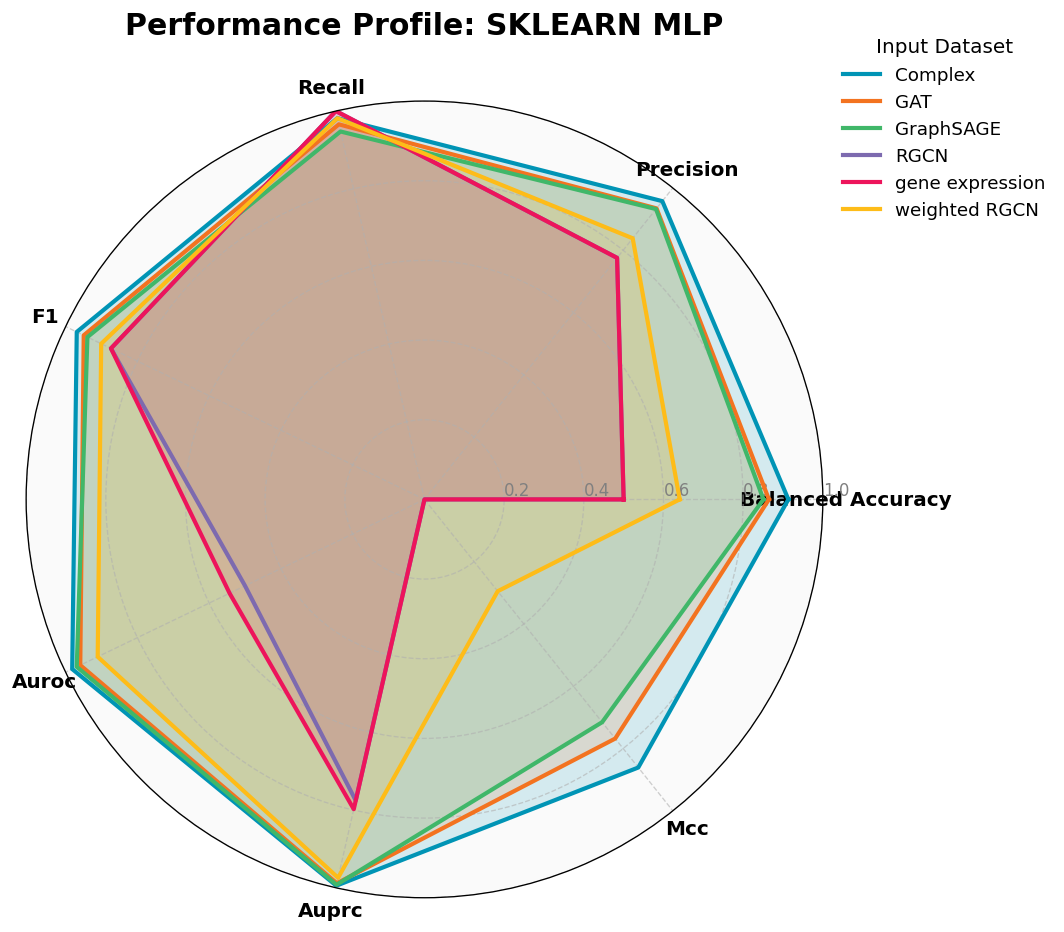

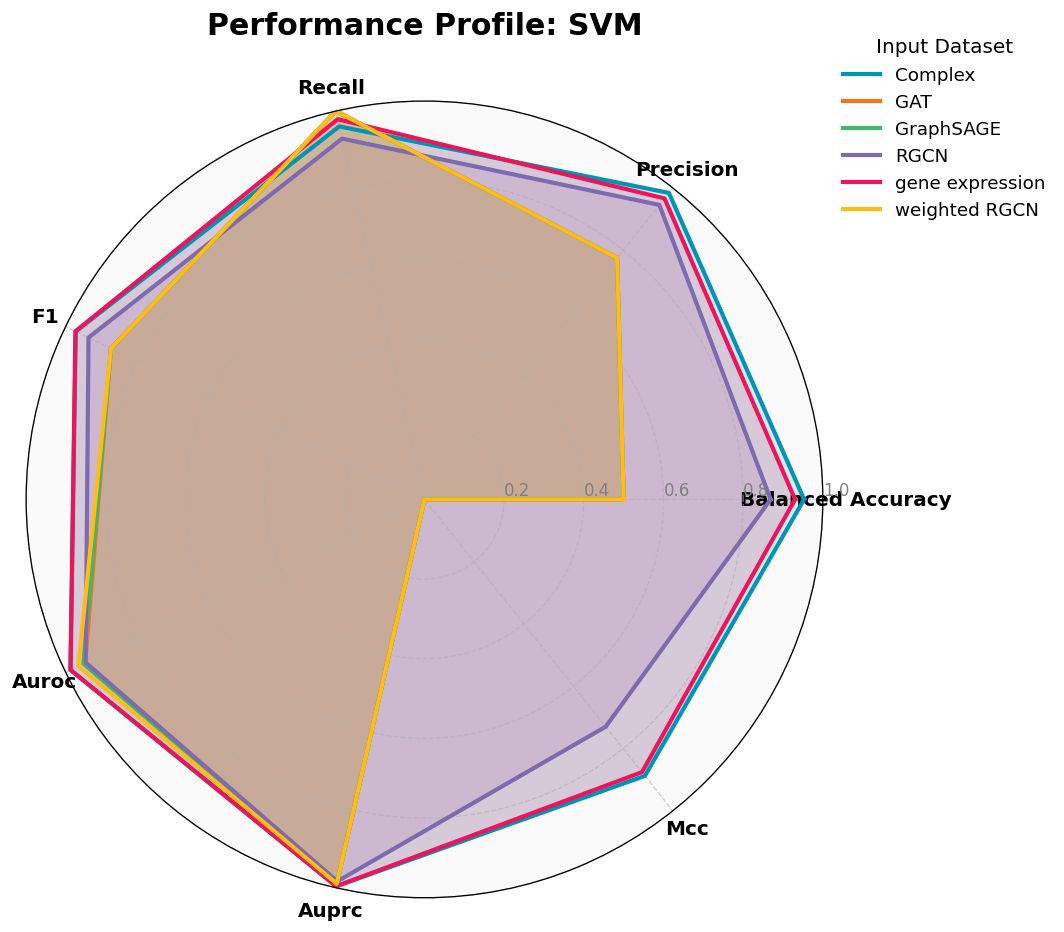

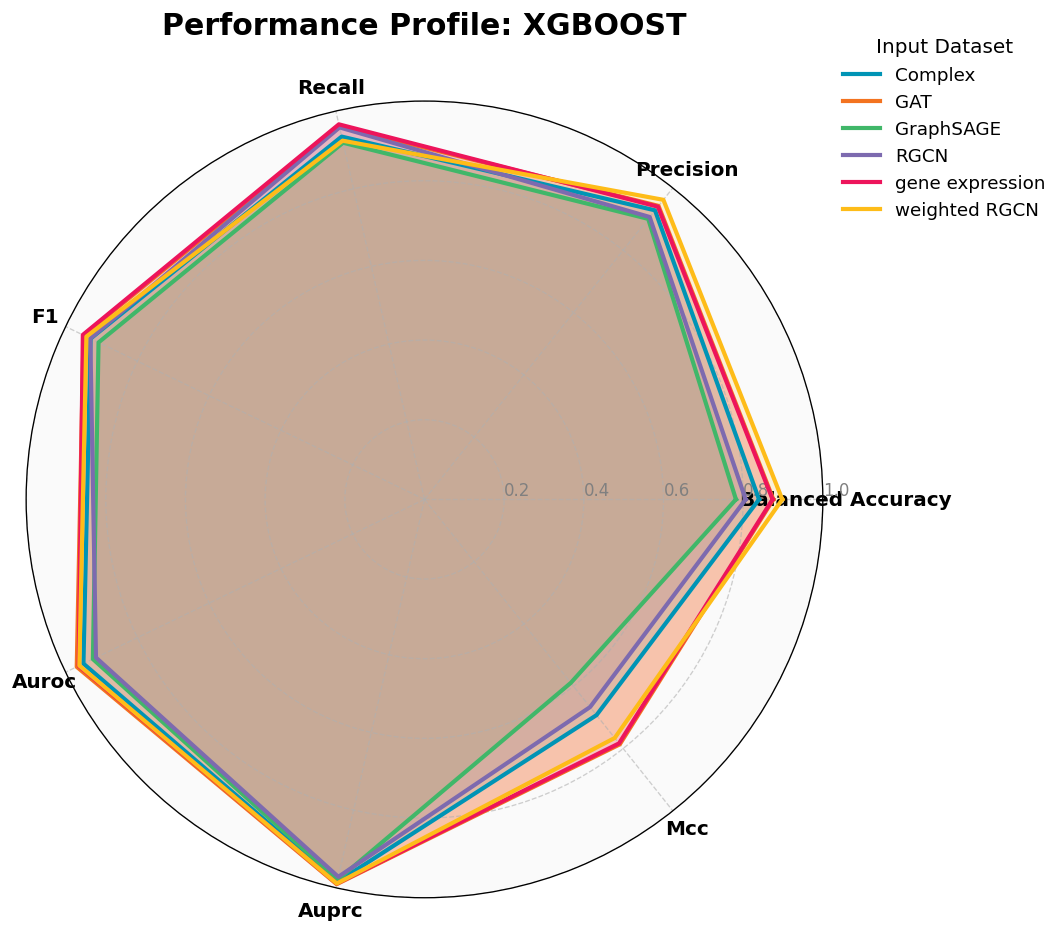

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Setup Metrics and Angles
metrics = ['balanced_accuracy', 'precision', 'recall', 'f1','auroc','auprc','mcc']
num_vars = len(metrics)

# Compute angles for each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Close the circular plot


# 3. Filter data for the specific model

def plot_radar_charts(filtered_results,model_name):
    fig, ax = plt.subplots(figsize=(9, 9), subplot_kw=dict(polar=True), dpi=120)
    plt.rcParams.update({'font.family': 'sans-serif'})

    model_df = filtered_results[filtered_results['model'] == model_name]

    # 4. Plot each Dataset Input
    for inp in model_df['input'].unique():
        # Calculate means for the metrics
        values = model_df[model_df['input'] == inp][metrics].mean().values.flatten().tolist()
        values += values[:1]  # Close the loop
        
        color = dataset_colors.get(inp, "#808080")
        clean_label = inp.replace('_protein_embeddings', '').replace('_', ' ')
        
        # Draw the outline
        ax.plot(angles, values, linewidth=2.5, linestyle='solid', label=clean_label, color=color)
        # Fill the area with a subtle alpha
        ax.fill(angles, values, color=color, alpha=0.15)

    # 5. Professional Styling
    # Set the metric labels at each angle
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels([m.replace('_', ' ').title() for m in metrics], size=12, weight='bold')

    # Set y-axis (Score) limits and labels
    ax.set_rlabel_position(0)
    plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], ["0.2", "0.4", "0.6", "0.8", "1.0"], 
            color="grey", size=10)
    plt.ylim(0, 1.0)

    # Customize the grid
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.set_facecolor('#FAFAFA') # Subtle off-white background

    # 6. Title and Legend
    plt.title(f'Performance Profile: {model_name.replace("_", " ").upper()}', 
            size=18, weight='bold', pad=40)

    plt.legend(
        loc='upper right', 
        bbox_to_anchor=(1.3, 1.1), 
        frameon=False,
        fontsize=11,
        title='Input Dataset',
        title_fontsize=12
    )

    plt.tight_layout()
    # -- save this in ../../../results/figures/metrics/radar_{model_name}.png
    plt.savefig(f'../../../results/figures/metrics/protein_radar_{model_name}.png', dpi=120, bbox_inches='tight')
    plt.show()

for model in filtered_results['model'].unique():
    plot_radar_charts(filtered_results, model)


To be more readbale better make a radar plot per model (one for svm, one for xgboost...)

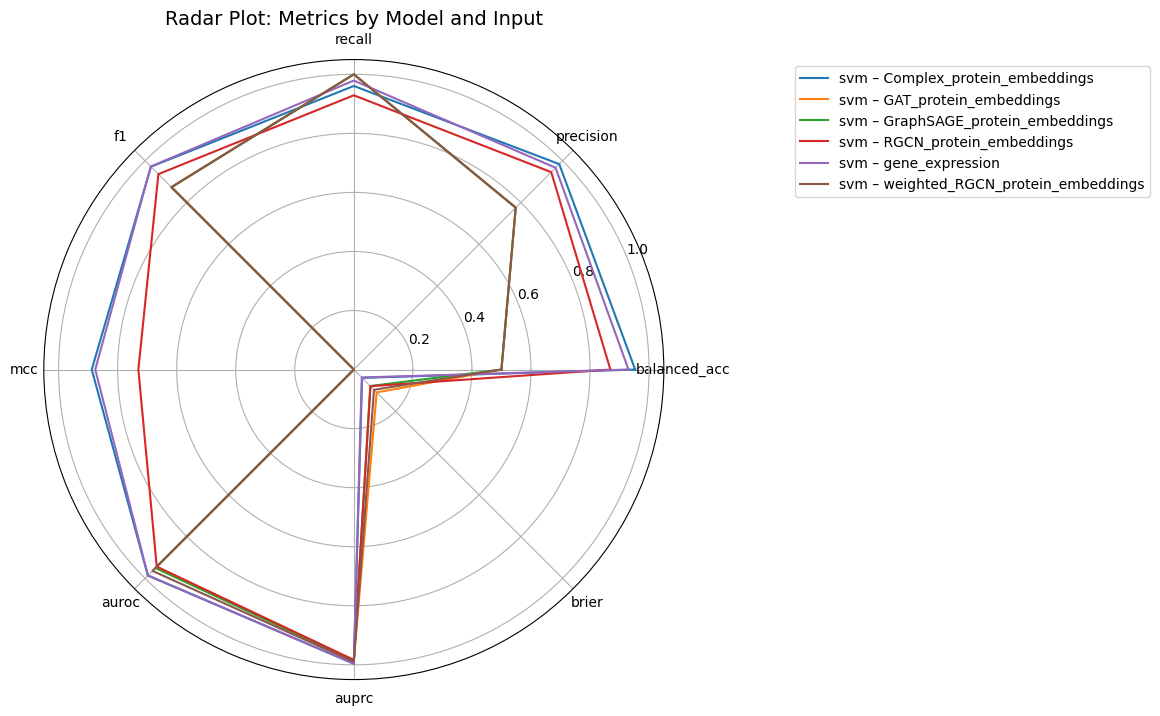

In [28]:
collector = ResultsCollector()
svm_filtered_results=filtered_results[filtered_results['model']=='svm']
dashboard = DashboardVisualizer(svm_filtered_results, collector)
dashboard.plot_radar()

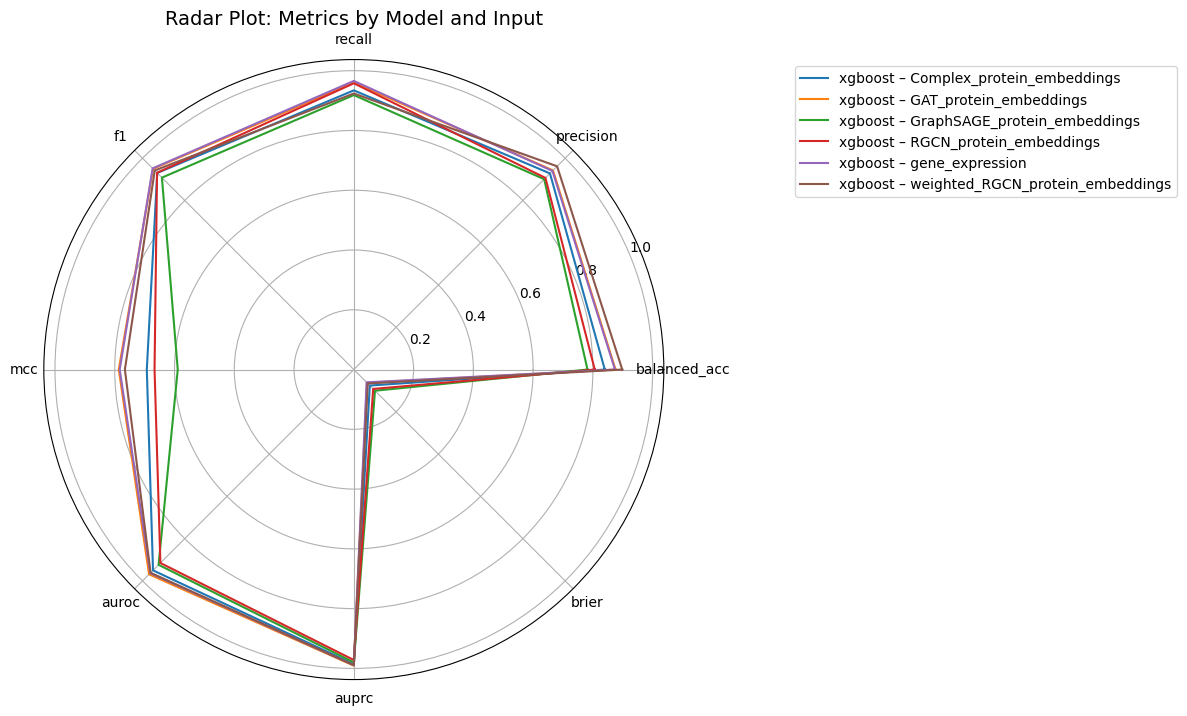

In [29]:
collector = ResultsCollector()
xgboost_filtered_results=filtered_results[filtered_results['model']=='xgboost']
dashboard = DashboardVisualizer(xgboost_filtered_results, collector)
dashboard.plot_radar()


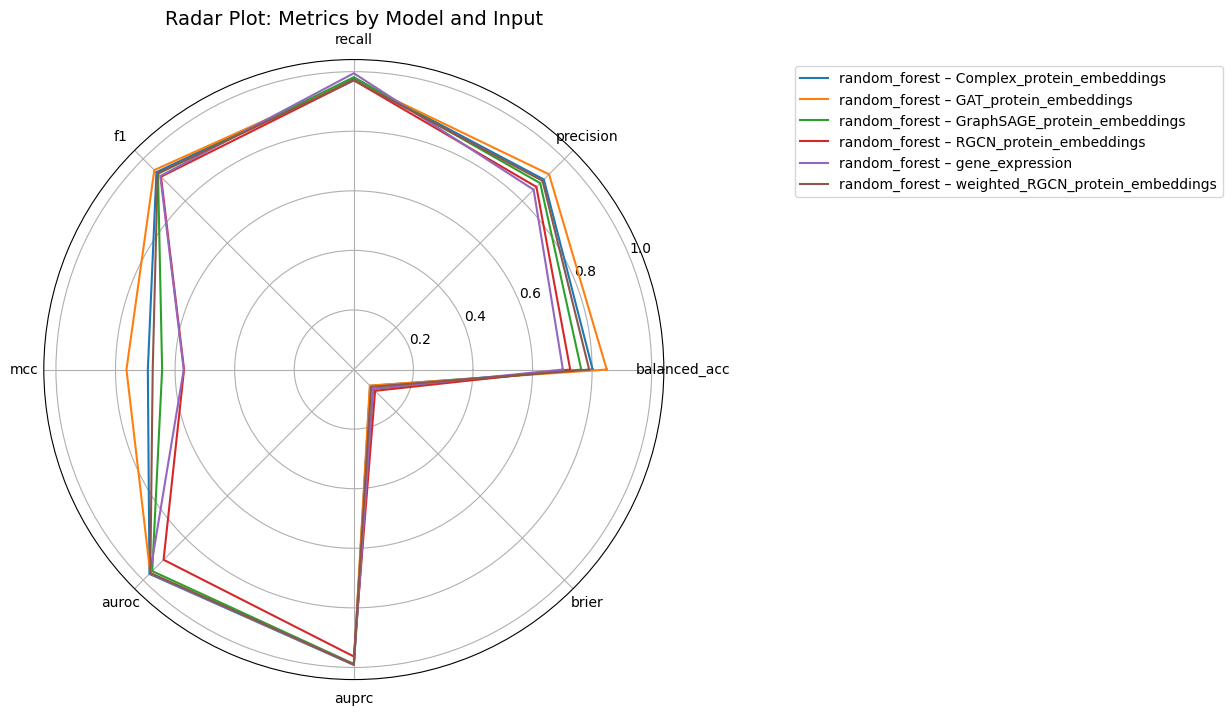

In [30]:
collector = ResultsCollector()
random_forest_filtered_results=filtered_results[filtered_results['model']=='random_forest']
dashboard = DashboardVisualizer(random_forest_filtered_results, collector)
dashboard.plot_radar()

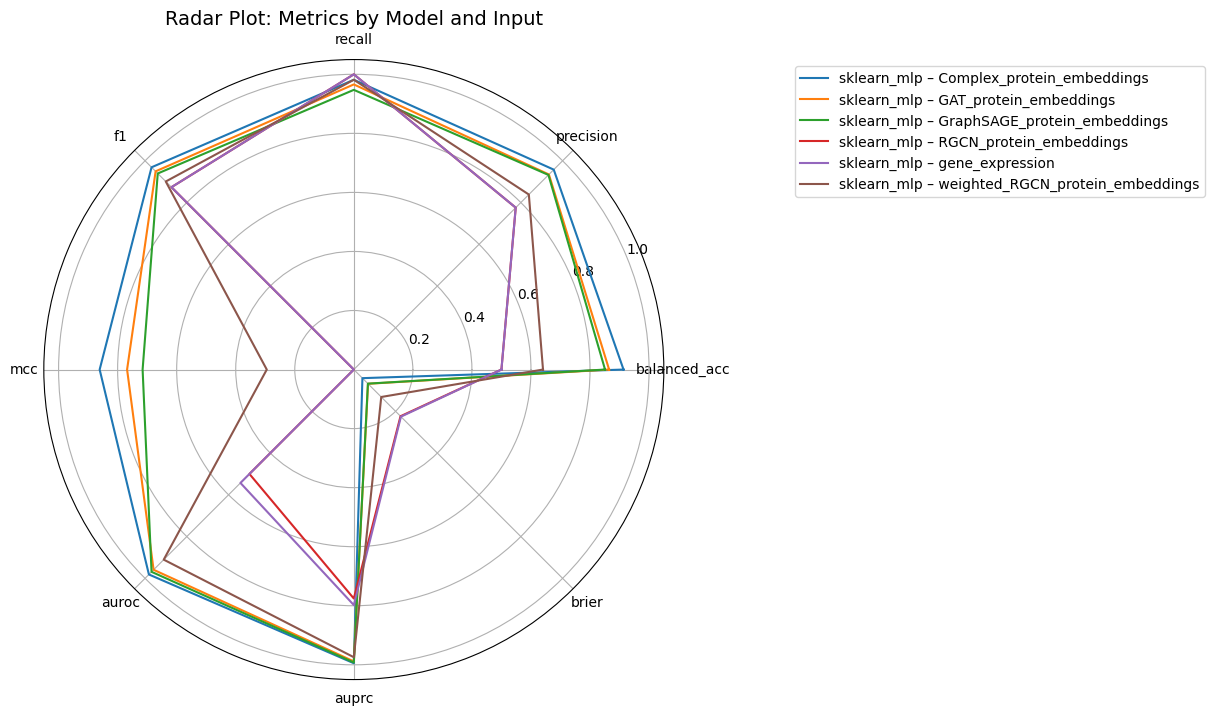

In [31]:
collector = ResultsCollector()
sklearn_mlp_filtered_results=filtered_results[filtered_results['model']=='sklearn_mlp']
dashboard = DashboardVisualizer(sklearn_mlp_filtered_results, collector)
dashboard.plot_radar()

In [32]:
# collector = ResultsCollector()
# pytorch_mlp_filtered_results=filtered_results[filtered_results['model']=='pytorch_mlp']
# dashboard = DashboardVisualizer(pytorch_mlp_filtered_results, collector)
# dashboard.plot_radar()